In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(18712, 28)
(18712, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, 22] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [8]:
X_motion_FR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.71802564e-02,
       -6.32287577e-04,  9.14495711e-03, -1.35179068e-04,  1.55370941e-03,
       -2.33552539e-03,  1.06805214e+02,  8.66421606e-02,  2.64182469e-02,
        1.06808211e+02, -1.92459331e-01,  2.64378912e-02,  1.06327835e+02,
        8.62278498e-02,  2.64315821e-02,  1.06325134e+02, -1.93213415e-01,
        2.64516712e-02,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_FR_swinging[0, :]

array([-0.00740647, -0.01888334, -0.00686052,  0.016514  ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9809768997434022
RMSE:  0.01136037533582274
The lowest error is:  9.91618928330995e-07
The highest error is:  0.08214056358734548
The avg. error is:  0.008180473906969282


In [11]:
model_fr_relative_swinging_x.coef_

array([[-3.97652821e-02, -9.83015301e-03,  2.51965977e-02,
         2.11229429e-01, -3.91925928e-02,  7.02450056e-03,
         5.28612914e-01, -1.09043022e-01, -4.48661288e-01,
         2.06748049e-01, -3.90183751e-01,  1.68823627e-04,
         3.10223122e-01, -9.79540485e-02]])

In [12]:
model_fr_relative_swinging_x.intercept_

array([-0.00523026])

Text(0, 0.5, 'Predictions')

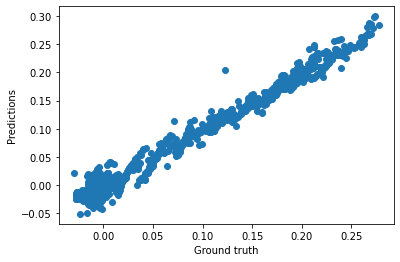

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_fr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [18]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8773337891879349
RMSE:  0.016025223513427025
The lowest error is:  4.136242479324884e-06
The highest error is:  0.16708417386945204
The avg. error is:  0.011266713063399282


In [19]:
model_fr_relative_swinging_y.coef_

array([[ 0.02336593, -0.02594122, -0.03288898, -0.01180073,  0.22048021,
        -0.01493796,  0.08161266,  0.50628582, -0.24680032, -0.38043102,
         0.10366489, -0.28316007,  0.06152352,  0.15712614]])

In [20]:
model_fr_relative_swinging_y.intercept_

array([-0.00424478])

Text(0, 0.5, 'Predictions')

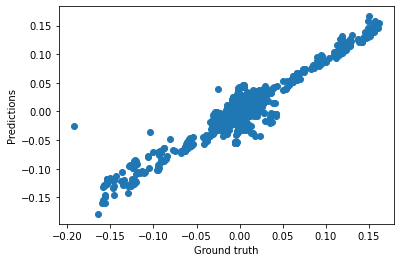

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#%store model_fr_relative_swinging_y

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [37]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")